In [1]:
import os
import sys
sys.path.append("./ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pickle
import pandas as pd
import scipy.special
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
#from bernstein import bernstesin_coeff_order10_new
from utils import *
from ddn.pytorch.node import AbstractDeclarativeNode

from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

In [2]:
# !TMPDIR=/home/vikrant pip install --cache-dir=/home/vikrant/ --build /home/vikrant/ pandas

#### CUDA Initializations

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [4]:
def bernstein_coeff_order10_new(n, tmin, tmax, t_actual):
    l = tmax - tmin
    t = (t_actual - tmin) / l

    P0 = scipy.special.binom(n, 0) * ((1 - t) ** (n - 0)) * t ** 0
    P1 = scipy.special.binom(n, 1) * ((1 - t) ** (n - 1)) * t ** 1
    P2 = scipy.special.binom(n, 2) * ((1 - t) ** (n - 2)) * t ** 2
    P3 = scipy.special.binom(n, 3) * ((1 - t) ** (n - 3)) * t ** 3
    P4 = scipy.special.binom(n, 4) * ((1 - t) ** (n - 4)) * t ** 4
    P5 = scipy.special.binom(n, 5) * ((1 - t) ** (n - 5)) * t ** 5
    P6 = scipy.special.binom(n, 6) * ((1 - t) ** (n - 6)) * t ** 6
    P7 = scipy.special.binom(n, 7) * ((1 - t) ** (n - 7)) * t ** 7
    P8 = scipy.special.binom(n, 8) * ((1 - t) ** (n - 8)) * t ** 8
    P9 = scipy.special.binom(n, 9) * ((1 - t) ** (n - 9)) * t ** 9
    P10 = scipy.special.binom(n, 10) * ((1 - t) ** (n - 10)) * t ** 10

    P0dot = -10.0 * (-t + 1) ** 9
    P1dot = -90.0 * t * (-t + 1) ** 8 + 10.0 * (-t + 1) ** 9
    P2dot = -360.0 * t ** 2 * (-t + 1) ** 7 + 90.0 * t * (-t + 1) ** 8
    P3dot = -840.0 * t ** 3 * (-t + 1) ** 6 + 360.0 * t ** 2 * (-t + 1) ** 7
    P4dot = -1260.0 * t ** 4 * (-t + 1) ** 5 + 840.0 * t ** 3 * (-t + 1) ** 6
    P5dot = -1260.0 * t ** 5 * (-t + 1) ** 4 + 1260.0 * t ** 4 * (-t + 1) ** 5
    P6dot = -840.0 * t ** 6 * (-t + 1) ** 3 + 1260.0 * t ** 5 * (-t + 1) ** 4
    P7dot = -360.0 * t ** 7 * (-t + 1) ** 2 + 840.0 * t ** 6 * (-t + 1) ** 3
    P8dot = 45.0 * t ** 8 * (2 * t - 2) + 360.0 * t ** 7 * (-t + 1) ** 2
    P9dot = -10.0 * t ** 9 + 9 * t ** 8 * (-10.0 * t + 10.0)
    P10dot = 10.0 * t ** 9

    P0ddot = 90.0 * (-t + 1) ** 8
    P1ddot = 720.0 * t * (-t + 1) ** 7 - 180.0 * (-t + 1) ** 8
    P2ddot = 2520.0 * t ** 2 * (-t + 1) ** 6 - 1440.0 * t * (-t + 1) ** 7 + 90.0 * (-t + 1) ** 8
    P3ddot = 5040.0 * t ** 3 * (-t + 1) ** 5 - 5040.0 * t ** 2 * (-t + 1) ** 6 + 720.0 * t * (-t + 1) ** 7
    P4ddot = 6300.0 * t ** 4 * (-t + 1) ** 4 - 10080.0 * t ** 3 * (-t + 1) ** 5 + 2520.0 * t ** 2 * (-t + 1) ** 6
    P5ddot = 5040.0 * t ** 5 * (-t + 1) ** 3 - 12600.0 * t ** 4 * (-t + 1) ** 4 + 5040.0 * t ** 3 * (-t + 1) ** 5
    P6ddot = 2520.0 * t ** 6 * (-t + 1) ** 2 - 10080.0 * t ** 5 * (-t + 1) ** 3 + 6300.0 * t ** 4 * (-t + 1) ** 4
    P7ddot = -360.0 * t ** 7 * (2 * t - 2) - 5040.0 * t ** 6 * (-t + 1) ** 2 + 5040.0 * t ** 5 * (-t + 1) ** 3
    P8ddot = 90.0 * t ** 8 + 720.0 * t ** 7 * (2 * t - 2) + 2520.0 * t ** 6 * (-t + 1) ** 2
    P9ddot = -180.0 * t ** 8 + 72 * t ** 7 * (-10.0 * t + 10.0)
    P10ddot = 90.0 * t ** 8
    90.0 * t ** 8

    P = np.hstack((P0, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10))
    Pdot = np.hstack((P0dot, P1dot, P2dot, P3dot, P4dot, P5dot, P6dot, P7dot, P8dot, P9dot, P10dot)) / l
    Pddot = np.hstack((P0ddot, P1ddot, P2ddot, P3ddot, P4ddot, P5ddot, P6ddot, P7ddot, P8ddot, P9ddot, P10ddot)) / (l ** 2)
    return P, Pdot, Pddot

In [5]:
# rho_obs = 0.3
rho_obs = 1.2
rho_eq = 10.0
weight_smoothness = 10

In [6]:
num = 30
t_fin = 5
a_obs = 1.0
b_obs = 1.0

tot_time = np.linspace(0.0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(num, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
nvar = np.shape(P)[1]
nvar

11

In [7]:
# x_obs_temp = np.hstack((-10.0, -10.79, -10, -10))
# y_obs_temp = np.hstack((10.0, 15.0, 15, 15))
x_obs_temp = np.hstack((-2.0, -5.79, 3.0, 4.0))
y_obs_temp = np.hstack((-2.0, 2.0, -0.80, 2.0))
num_obs = np.shape(x_obs_temp)[0]

x_obs = np.ones((num_obs, num)) * x_obs_temp[:, np.newaxis]
y_obs = np.ones((num_obs, num)) * y_obs_temp[:, np.newaxis]

In [8]:
obs_inp_list = []
for i in range(num_obs):
    obs_inp_list.extend([x_obs_temp[i], y_obs_temp[i], a_obs])

obs_inp = np.array(obs_inp_list)
# obs_inp

In [9]:
A_obs = np.tile(P, (num_obs, 1))
A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
Q_smoothness = np.dot(Pddot.T, Pddot)

In [10]:
# A_obs

In [11]:
class OPTNode(AbstractDeclarativeNode):
    def __init__(self, P, Pddot, A_eq, A_obs, Q_smoothness, x_obs, y_obs, num=12, num_obs=4, nvar=11, a_obs=1.0, b_obs=1.0, rho_obs=0.3, rho_eq=10.0, weight_smoothness=10, maxiter=300, eps=1e-7, num_tot=48):
        super().__init__()
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.Pddot = torch.tensor(Pddot, dtype=torch.double).to(device)
        self.A_eq = torch.tensor(A_eq, dtype=torch.double).to(device)
        self.A_obs = torch.tensor(A_obs, dtype=torch.double).to(device)
        self.Q_smoothness = torch.tensor(Q_smoothness, dtype=torch.double).to(device)
        self.x_obs = torch.tensor(x_obs, dtype=torch.double).to(device)
        self.y_obs = torch.tensor(y_obs, dtype=torch.double).to(device)
        
        self.num = num
        self.num_obs = num_obs
        self.eps = eps
        self.nvar = nvar        
        self.a_obs = a_obs
        self.b_obs = b_obs        
        self.rho_eq = rho_eq
        self.num_obs = num_obs
        self.maxiter = maxiter
        self.num_tot = num_tot
        self.rho_obs = rho_obs
        self.weight_smoothness = weight_smoothness
        
    def objective(self, b, lamda_x, lamda_y, y):  
        batch_size, _ = b.size()
        b = b.transpose(0, 1)
        y = y.transpose(0, 1)
        lamda_x = lamda_x.transpose(0, 1)
        lamda_y = lamda_y.transpose(0, 1)
        bx_eq_tensor, by_eq_tensor = torch.split(b, 6, dim=0)
        ones_tensor = torch.ones(self.num_tot, batch_size, dtype=torch.double).to(device)

        c_x = y[0:self.nvar]
        c_y = y[self.nvar:2 * self.nvar]

        cost_smoothness_x = 0.5 * self.weight_smoothness * torch.diag(torch.matmul(c_x.T, torch.matmul(self.Q_smoothness, c_x)))
        cost_smoothness_y = 0.5 * self.weight_smoothness * torch.diag(torch.matmul(c_y.T, torch.matmul(self.Q_smoothness, c_y)))

        cost_eq_x = 0.5 * self.rho_eq * torch.sum((torch.matmul(self.A_eq, c_x) - bx_eq_tensor) ** 2, axis=0)
        cost_eq_y = 0.5 * self.rho_eq * torch.sum((torch.matmul(self.A_eq, c_y) - by_eq_tensor) ** 2, axis=0)

        cost_x = cost_smoothness_x + cost_eq_x - torch.diag(torch.matmul(lamda_x.transpose(0, 1), c_x))
        cost_y = cost_smoothness_y + cost_eq_y - torch.diag(torch.matmul(lamda_y.transpose(0, 1), c_y))

        cost = cost_x + cost_y + self.eps * torch.sum(c_x ** 2, axis=0) + self.eps * torch.sum(c_y ** 2, axis=0)# + self.eps * torch.sum(d_obs ** 2, axis=0) + self.eps * torch.sum(alpha_obs ** 2, axis=0) + cost_slack
        return cost
    
    def optimize(self, b, lamda_x, lamda_y):
        bx_eq_tensor, by_eq_tensor = torch.split(b, 6, dim=0)
        
        d_obs = torch.ones(self.num_obs, self.num, dtype=torch.double).to(device)
        alpha_obs = torch.zeros(self.num_obs, self.num, dtype=torch.double).to(device)
        ones_tensor = torch.ones((self.num_obs, self.num), dtype=torch.double).to(device)
        cost_smoothness = self.weight_smoothness * torch.matmul(self.Pddot.T, self.Pddot)
        cost = cost_smoothness + self.rho_eq * torch.matmul(self.A_eq.T, self.A_eq)

        for i in range(self.maxiter):
            lincost_x = -lamda_x - self.rho_eq * torch.matmul(self.A_eq.T, bx_eq_tensor)
            lincost_y = -lamda_y - self.rho_eq * torch.matmul(self.A_eq.T, by_eq_tensor)          
            
            lincost_x = lincost_x.view(-1, 1)
            lincost_y = lincost_y.view(-1, 1)
            
            sol_x, _ = torch.solve(lincost_x, -cost)
            sol_y, _ = torch.solve(lincost_y, -cost)

            sol_x = sol_x.view(-1)
            sol_y = sol_y.view(-1)

            x = torch.matmul(self.P, sol_x)
            y = torch.matmul(self.P, sol_y)

            res_eq_x_vec = torch.matmul(self.A_eq, sol_x) - bx_eq_tensor
            res_eq_y_vec = torch.matmul(self.A_eq, sol_y) - by_eq_tensor

            lamda_x -= self.rho_eq * torch.matmul(self.A_eq.T, res_eq_x_vec)
            lamda_y -= self.rho_eq * torch.matmul(self.A_eq.T, res_eq_y_vec)

        sol = torch.cat([sol_x, sol_y])
        return sol
        
    def solve(self, b, lamda_x, lamda_y):
        batch_size, _ = b.size()
        b = b.transpose(0, 1)
        lamda_x = lamda_x.transpose(0, 1)
        lamda_y = lamda_y.transpose(0, 1)
        y = torch.zeros(batch_size, 2 * self.nvar, dtype=torch.double).to(device)
        for i in range(batch_size):
            b_cur = b[:, i]
            lamda_x_cur = lamda_x[:, i]
            lamda_y_cur = lamda_y[:, i]
            sol = self.optimize(b_cur, lamda_x_cur, lamda_y_cur)
            y[i, :] = sol
        return y, None

#### PyTorch Declarative Function

In [12]:
class OptFunction(torch.autograd.Function):
    """Generic declarative autograd function.
    Defines the forward and backward functions. Saves all inputs and outputs,
    which may be memory-inefficient for the specific problem.
    
    Assumptions:
    * All inputs are PyTorch tensors
    * All inputs have a single batch dimension (b, ...)
    """
    @staticmethod
    def forward(ctx, problem, *inputs):
        output, solve_ctx = torch.no_grad()(problem.solve)(*inputs)
        ctx.save_for_backward(output, *inputs)
        ctx.problem = problem
        ctx.solve_ctx = solve_ctx
        return output.clone()

    @staticmethod
    def backward(ctx, grad_output):
        output, *inputs = ctx.saved_tensors
        problem = ctx.problem
        solve_ctx = ctx.solve_ctx
        output.requires_grad = True
        inputs = tuple(inputs)
        grad_inputs = problem.gradient(*inputs, y=output, v=grad_output,
            ctx=solve_ctx)
        return (None, *grad_inputs)

#### PyTorch Declarative Layer

In [13]:
class OptLayer(torch.nn.Module):
    """Generic declarative layer.
    
    Assumptions:
    * All inputs are PyTorch tensors
    * All inputs have a single batch dimension (b, ...)
    Usage:
        problem = <derived class of *DeclarativeNode>
        declarative_layer = DeclarativeLayer(problem)
        y = declarative_layer(x1, x2, ...)
    """
    def __init__(self, problem):
        super(OptLayer, self).__init__()
        self.problem = problem
        
    def forward(self, *inputs):
        return OptFunction.apply(self.problem, *inputs)

#### TrajNet

In [128]:
class TrajNet(nn.Module):
    def __init__(self, opt_layer, P, input_size=16, hidden_size=64, output_size=12, nvar=11, t_obs=8):
        super(TrajNet, self).__init__()
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.nvar = nvar
        self.t_obs = t_obs
        self.linear1 = nn.Linear(input_size, 64)
        self.lstm = nn.LSTMCell(64, 32)
        self.linear2 = nn.Linear(64, output_size)
        self.opt_layer = opt_layer
        self.activation = nn.ReLU()
        self.mask = torch.tensor([[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]], dtype=torch.double)
    
    def forward(self, x, b):
        batch_size, _ = x.size()
        out = self.activation(self.linear1(x))
#         out = self.lstm(out)[0]
        b_pred = self.linear2(out)
        b_gen = self.mask * b + (1 - self.mask) * b_pred
        
        print(b_pred.shape)
        print(b_gen.shape)
        # Run optimization
        lamda_x = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(device)
        lamda_y = torch.zeros(batch_size, self.nvar, dtype=torch.double).to(device)
        sol = self.opt_layer(b_gen, lamda_x, lamda_y)
        # Compute final trajectory
        x_pred = torch.matmul(self.P, sol[:, :self.nvar].transpose(0, 1))
        y_pred = torch.matmul(self.P, sol[:, self.nvar:2*self.nvar].transpose(0, 1))
        
        x_pred = x_pred.transpose(0, 1)
        y_pred = y_pred.transpose(0, 1)
        out = torch.cat([x_pred, y_pred], dim=1)
        return out

In [129]:
opt_node = OPTNode(
    P, 
    Pddot, 
    A_eq,
    A_obs, 
    Q_smoothness, 
    x_obs,
    y_obs,
    num=num, 
    num_obs=num_obs, 
    nvar=nvar, 
    a_obs=a_obs, 
    b_obs=b_obs, 
    rho_obs=rho_obs, 
    rho_eq=rho_eq,
    weight_smoothness=weight_smoothness, 
    maxiter=300, 
    eps=1e-7, 
    num_tot=num*num_obs
)
opt_layer = OptLayer(opt_node)

In [130]:
num_elems = 5
total_size = 20 * 2 + 4 #+ num_elems * 2

In [131]:
model = TrajNet(opt_layer, P, total_size)
model = model.double()
model = model.to(device)

#### Model Testing

In [132]:
x_inp = torch.randn(10, total_size, dtype=torch.double)
y_out = torch.randn(10, 60, dtype=torch.double)
b_inp = torch.randn(10, 12, dtype=torch.double)

In [133]:
print(x_inp.shape)

torch.Size([10, 44])


In [134]:
out = model(x_inp, b_inp)
out.size()

torch.Size([10, 12])
torch.Size([10, 12])


torch.Size([10, 60])

## Dataloaders

In [135]:
class ArgoverseDataset(Dataset):
    def __init__(self, file_name, t_obs=20, dt=1, num_elems = 5):
        self.file_name = file_name
        self.t_obs = t_obs
        self.dt = dt
        self.num_elems = num_elems
        self.data = []
        with open(file_name, 'rb') as f:
            gt = pd.read_pickle(f)
            self.gt = gt
            data = [[[ j[3], j[4]] for j in gt["FEATURES"].values[i]] for i in range(len(gt["FEATURES"].values))  ]
            self.data = np.array(data)[:100]
#             print(np.array(data).shape)
            self.centerlines = gt["ORACLE_CENTERLINE"].values[:100]
#             print(self.data.shape)
#             print(self.centerlines.shape)
    
    def __len__(self):
        return len(self.data)
    
    def get_vel(self, pos):
        return (pos[-1] - pos[-2]) / self.dt
    
    def get_acc(self, vel):
        return (vel[-1] - vel[-2]) / self.dt
    
    def __getitem__(self, idx):
        data = self.data
        x_traj = data[idx][:, 0]
        x_traj -= x_traj[0]
        y_traj = data[idx][:, 1]
        y_traj -= y_traj[0]
#         plt.plot(x_traj, y_traj)
        
        x_inp = x_traj[:self.t_obs]
        y_inp = y_traj[:self.t_obs]
        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
        
        vx_beg = (x_inp[-1] - x_inp[-2]) / self.dt
        vy_beg = (y_inp[-1] - y_inp[-2]) / self.dt

        vx_fin = (x_fut[-1] - x_fut[-2]) / self.dt
        vy_fin = (y_fut[-1] - y_fut[-2]) / self.dt
        vel_acc = np.array([vx_beg, vy_beg, vx_fin, vy_fin])
        traj_inp = np.hstack((x_inp, y_inp)).flatten()
        idxs = np.round(np.linspace(0, len(self.centerlines[idx]) - 1, self.num_elems)).astype(int)
        cx = [self.centerlines[idx][i][0] for i in idxs]
        cy = [self.centerlines[idx][i][1] for i in idxs]
#         traj_inp = np.hstack((traj_inp, vel_acc))        
#         traj_out = np.hstack((x_fut, y_fut)).flatten()
#         b_inp = np.array([x_fut[0], vx_beg, 0, x_fut[-1], 0, 0, y_fut[0], vy_beg, 0, y_fut[-1], 0, 0])    

        vx_beg = (x_inp[-1] - x_inp[-2]) / self.dt
        vy_beg = (y_inp[-1] - y_inp[-2]) / self.dt
        
        vx_beg_prev = (x_inp[-2] - x_inp[-3]) / self.dt
        vy_beg_prev = (y_inp[-2] - y_inp[-3]) / self.dt
        
        ax_beg = (vx_beg - vx_beg_prev) / self.dt
        ay_beg = (vy_beg - vy_beg_prev) / self.dt
        
        vel_acc_inp = np.array([vx_beg, vy_beg, ax_beg, ay_beg])
        
        traj_inp = np.hstack((x_inp, y_inp)).flatten()
        traj_inp = np.hstack((traj_inp, vel_acc_inp))
        traj_out = np.hstack((x_fut, y_fut)).flatten()
#         self.mask = torch.tensor([[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]], dtype=torch.double)        
        b_inp = np.array([x_inp[-1], vx_beg, ax_beg, 20, 0, 0, y_inp[-1], vy_beg, ay_beg, 10, 0, 0])        
        return torch.tensor(traj_inp), torch.tensor(traj_out), torch.tensor(b_inp)    

In [136]:
# train_dataset = ArgoverseDataset("/datasets/argoverse/sample.pkl")
train_dataset = ArgoverseDataset("/datasets/argoverse/forecasting_features_val.pkl")
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, num_workers=0)

KeyboardInterrupt: 

In [125]:
def plot_traj(cnt, traj_inp, traj_out, traj_pred, obs=[], b_inp = []):
    traj_inp = traj_inp.numpy()
    traj_out = traj_out.numpy()
    traj_pred = traj_pred.detach().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(traj_inp[:20], traj_inp[20:40], label='Inp traj')
    ax.scatter(traj_out[:30], traj_out[30:], label='GT')
    ax.scatter(traj_pred[:30], traj_pred[30:], label='Pred')

    ax.scatter(b_inp[0], b_inp[6], label='Initial')
    ax.scatter(b_inp[3], b_inp[9], label='Final')
    ax.legend()
    plt.savefig('./results/{}.png'.format(cnt))
    plt.close()

In [126]:
cnt = 0
for i, data in enumerate(train_loader):
    cnt = cnt + 1
    traj_inp, traj_out, b_inp = data
#     print(traj_inp.size(), traj_out.size(), b_inp.size())
    out = model(traj_inp, b_inp)
#     print(np.hstack((traj_inp[0], traj_out[0])).shape)
#     np.save("data.npy", np.hstack((traj_inp[0], traj_out[0])))
#     print(traj_inp[0][:20])
#     print(traj_inp[0][20:40])
#     print(traj_out[0][:30])
#     print(b_inp[0])
#     print(i)
    for ii in range(traj_inp.shape[0]):
        plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], obs=[], b_inp = b_inp[ii])
    if cnt > 1:
        break

torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])


#### Training

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [ ]:
traj_inp.size(), traj_out.size()

torch.Size([20, 12])
torch.Size([20, 12])
Epoch: 0, Batch: 0, Loss: 538.7529514255356
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
Epoch: 0, Mean Loss: 591.8002266694109
----------------------------------------------------------------------------------------------------
torch.Size([20, 12])
torch.Size([20, 12])
Epoch: 1, Batch: 0, Loss: 538.7529514255356
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
Epoch: 1, Mean Loss: 591.8002266694109
----------------------------------------------------------------------------------------------------
torch.Size([20, 12])
torch.Size([20, 12])
Epoch: 2, Batch: 0, Loss: 538.7529514255356
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])
torch.Size([20, 12])


KeyboardInterrupt: 

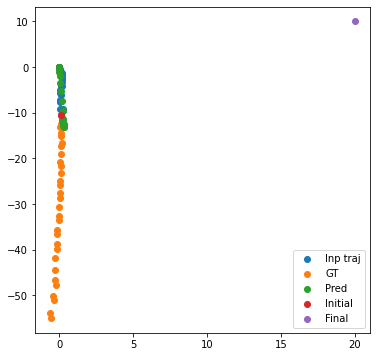

In [127]:
epoch_train_loss = []
num_epochs = 1000

for epoch in range(num_epochs):
    train_loss = []
    for batch_num, data in enumerate(train_loader):
        traj_inp, traj_out, b_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        b_inp = b_inp.to(device)

        out = model(traj_inp, b_inp)
        loss = criterion(out, traj_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        cnt = 0
        obs = np.load("train/obstacle.npy")
        for i in range(traj_inp.size()[0]):
            plot_traj(cnt, traj_inp[i], traj_out[i], out[i], {"x": x_obs_temp, "y": y_obs_temp}, b_inp=b_inp[i])
            cnt += 1
        
        if batch_num % 10 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, batch_num, loss.item()))
    
    mean_loss = np.mean(train_loss)
    epoch_train_loss.append(mean_loss)
    print("Epoch: {}, Mean Loss: {}".format(epoch, mean_loss))
    print("-"*100)

#### Testing

In [ ]:
plot_traj(1, traj_inp, traj_out, traj_pred)

In [ ]:
with torch.no_grad():
    cnt = 0
    test_loss = []
    for batch_num, data in enumerate(test_loader):
        traj_inp, traj_out, b_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        b_inp = b_inp.to(device)

        out = model(traj_inp, b_inp)
        loss = criterion(out, traj_out)
        
        test_loss.append(loss.item())
        obs = np.load("train/obstacle.npy")
        print("Batch: {}, Loss: {}".format(batch_num, loss.item()))
        for i in range(traj_inp.size()[0]):
            plot_traj(cnt, traj_inp[i], traj_out[i], out[i], {"x": obs[i][0], "y": obs[i][1]})
            cnt += 1
mean_loss = np.mean(test_loss)
print("Epoch Mean Test Loss: {}".format(mean_loss))

In [ ]:
traj_inp.numpy()[0][:2*num].shape, traj_out.numpy()[0].shape

In [ ]:
traj_inp[6]

In [ ]:
traj_out[6]

In [ ]:
out[6]

In [ ]:
torch.sqrt(torch.sum((traj_out[6] - out[6]) ** 2))

In [ ]:
fin = torch.tensor([traj_out[6][1], traj_out[6][23]])
fin_pred = torch.tensor([out[6][11], out[6][23]])
fin, fin_pred

In [ ]:
torch.sqrt(torch.sum((fin_pred - fin) ** 2))

In [ ]:
torch.sqrt(torch.sum((traj_out[6][-1] - out[6][-1]) ** 2))

In [ ]:
criterion(traj_out[6], out[6])

In [ ]:
def disp_traj(cnt, traj_inp, traj_out, traj_pred):
    traj_inp = traj_inp.numpy()
    traj_out = traj_out.numpy()
    traj_pred = traj_pred.numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(traj_inp[::2], traj_inp[1::2], label='Inp traj')
    ax.scatter(traj_out[:12], traj_out[12:], label='GT')
    ax.scatter(traj_out[11], traj_out[23], label='Fin GT')
    ax.scatter(traj_pred[:12], traj_pred[12:], label='Pred')
    ax.scatter(traj_pred[11], traj_pred[23], label='Fin Pred')
    
    th = np.linspace(0, 2 * np.pi, 100)
    for i in range(0, num_obs):
        x_circ = x_obs_temp[i] + a_obs * np.cos(th)
        y_circ = y_obs_temp[i] + b_obs * np.sin(th)
        ax.plot(x_circ, y_circ, '-k')
    
    ax.legend()
    ax.set_xlim([-7, 7])
    ax.set_ylim([-7, 7])
    plt.show()

In [ ]:
disp_traj(0, traj_inp[8], traj_out[8], out[8].detach())

(100, 2, 20)


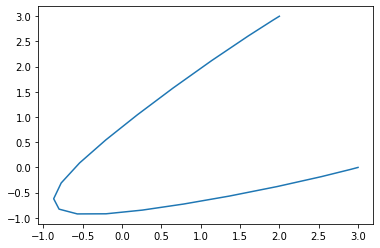

In [97]:
arr = np.load('train/test.npy')
print(arr.shape)